<a href="https://colab.research.google.com/github/MahdieRah/Protein_Feature_Extraction/blob/main/Analyze_RMSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload Two PDB Files in Google Colab
from google.colab import files
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# Upload first PDB file
print("Please upload the first PDB file")
uploaded_1 = files.upload()
pdb_file_1 = list(uploaded_1.keys())[0]

# Upload second PDB file
print("Please upload the second PDB file")
uploaded_2 = files.upload()
pdb_file_2 = list(uploaded_2.keys())[0]

print(f"Uploaded files: {pdb_file_1}, {pdb_file_2}")

Please upload the first PDB file


Saving 1ake.pdb to 1ake.pdb
Please upload the second PDB file


Saving 1crn.pdb to 1crn.pdb
Uploaded files: 1ake.pdb, 1crn.pdb


In [ ]:
# Parse the PDB file into a DataFrame
def parse_pdb_to_df(file_path):
    columns = ['atom_name', 'residue_name', 'chain_id', 'residue_number', 'x', 'y', 'z']
    data = []
    with open(file_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                atom_name = line[12:16].strip()
                residue_name = line[17:20].strip()
                chain_id = line[21].strip()
                residue_number = int(line[22:26].strip())
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                data.append([atom_name, residue_name, chain_id, residue_number, x, y, z])
    return pd.DataFrame(data, columns=columns)


In [ ]:
# Parse both PDB files into DataFrames
df_1 = parse_pdb_to_df(pdb_file_1)
df_2 = parse_pdb_to_df(pdb_file_2)


In [ ]:
print("\nSample of Structure 1 DataFrame:")
print(df_1.head())

print("\nSample of Structure 2 DataFrame:")
print(df_2.head())



Sample of Structure 1 DataFrame:
  atom_name residue_name chain_id  residue_number       x       y       z
0         N          MET        A               1  26.981  53.977  40.085
1        CA          MET        A               1  26.091  52.849  39.889
2         C          MET        A               1  26.679  52.163  38.675
3         O          MET        A               1  27.020  52.865  37.715
4        CB          MET        A               1  24.677  53.310  39.580

Sample of Structure 2 DataFrame:
  atom_name residue_name chain_id  residue_number       x       y      z
0         N          THR        A               1  17.047  14.099  3.625
1        CA          THR        A               1  16.967  12.784  4.338
2         C          THR        A               1  15.685  12.755  5.133
3         O          THR        A               1  15.268  13.825  5.594
4        CB          THR        A               1  18.170  12.703  5.337


In [ ]:
# Ensure Matching Atom Counts
min_atoms = min(len(df_1), len(df_2))
df_1 = df_1.iloc[:min_atoms]
df_2 = df_2.iloc[:min_atoms]

In [ ]:
# Extract Coordinates
coords_1 = df_1[['x', 'y', 'z']].to_numpy()
coords_2 = df_2[['x', 'y', 'z']].to_numpy()

In [ ]:
# Kabsch Algorithm for Structural Alignment
def kabsch_alignment(P, Q):
    P -= np.mean(P, axis=0)
    Q -= np.mean(Q, axis=0)

    H = P.T @ Q
    U, S, Vt = np.linalg.svd(H)

    if np.linalg.det(U @ Vt) < 0:
        Vt[-1, :] *= -1

    R = U @ Vt
    P_aligned = P @ R

    return P_aligned, R


In [ ]:
# Align Structure 1 to Structure 2
aligned_coords_1, rotation_matrix = kabsch_alignment(coords_1.copy(), coords_2.copy())

In [ ]:
# RMSD Calculation
def calculate_rmsd(P, Q):
    return np.sqrt(np.mean(np.sum((P - Q) ** 2, axis=1)))

rmsd_after_alignment = calculate_rmsd(aligned_coords_1, coords_2)
print(f"\nRMSD after alignment: {rmsd_after_alignment:.4f} Å")



RMSD after alignment: 18.0232 Å


In [ ]:
# Add Aligned Coordinates to DataFrame
df_1[['x_aligned', 'y_aligned', 'z_aligned']] = aligned_coords_1

In [ ]:
# Analyze Differences Using Pandas
# (a) Per-Residue RMSD Calculation
def calculate_per_residue_rmsd(P, Q):
    return np.sqrt(np.sum((P - Q) ** 2, axis=1))

df_1['rmsd_per_residue'] = calculate_per_residue_rmsd(aligned_coords_1, coords_2)

# (b) Identify Flexible Regions
flexibility_threshold = 2.0
df_flexible = df_1[df_1['rmsd_per_residue'] > flexibility_threshold]
print("\nFlexible Regions (RMSD > 2.0 Å):")
print(df_flexible[['residue_name', 'residue_number', 'rmsd_per_residue']])



Flexible Regions (RMSD > 2.0 Å):
    residue_name  residue_number  rmsd_per_residue
0            MET               1         32.404683
1            MET               1         32.553620
2            MET               1         30.311120
3            MET               1         29.236205
4            MET               1         34.201893
..           ...             ...               ...
322          LEU              45          5.113944
323          LEU              45          7.456359
324          LEU              45          7.684774
325          LEU              45          9.390230
326          LEU              45          9.655974

[327 rows x 3 columns]


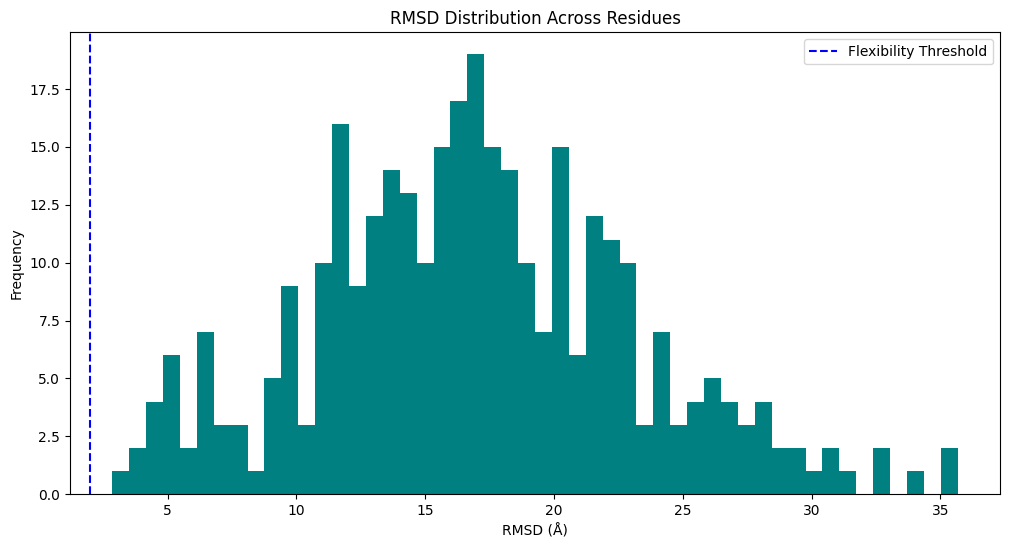

In [ ]:
# Visualize RMSD Distribution
plt.figure(figsize=(12, 6))
plt.hist(df_1['rmsd_per_residue'], bins=50, color='teal')
plt.axvline(flexibility_threshold, color='blue', linestyle='--', label='Flexibility Threshold')
plt.title("RMSD Distribution Across Residues")
plt.xlabel("RMSD (Å)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
# Save Processed Data to CSV
df_1.to_csv('aligned_protein_analysis.csv', index=False)
print("\nAligned protein analysis saved to 'aligned_protein_analysis.csv'")


Aligned protein analysis saved to 'aligned_protein_analysis.csv'


In [ ]:
# Output Rotation Matrix
print("\nOptimal Rotation Matrix:")
print(rotation_matrix)



Optimal Rotation Matrix:
[[ 0.12052555  0.69849545  0.70539188]
 [ 0.15704121  0.68820861 -0.70831276]
 [-0.98021     0.19614538 -0.02674585]]
